In [1]:
NOTE = 'CatBoostベクトルは除外'
notebook_name = '042'

In [2]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

042_submission.csv 042


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])
# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(12, 384, 107)

In [6]:
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [7]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [8]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [9]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [10]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [11]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    # feature transformation
    ## categorical features
    X_train_categorical = X_train.copy()[categorical_features]
    X_valid_categorical = X_valid.copy()[categorical_features]
    X_test_categorical = test.copy()[categorical_features]
    ## descrete features
    X_train_discrete = X_train.copy()[discrete_features]
    X_valid_discrete = X_valid.copy()[discrete_features]
    X_test_discrete = test.copy()[discrete_features]
    ## vector features
    """
    vector_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('decomposer', PCA(n_components=0.8, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[vector_features])
    columns = [f'pca{i + 1}' for i in range(vector_transformer[-1].n_components_)]
    X_train_vector = pd.DataFrame(
        data=vector_transformer.transform(X_train.copy()[vector_features]),
        columns=columns,
        index=train_idx
    )
    X_valid_vector = pd.DataFrame(
        data=vector_transformer.transform(X_valid.copy()[vector_features]),
        columns=columns,
        index=valid_idx
    )
    X_test_vector = pd.DataFrame(
        data=vector_transformer.transform(test.copy()[vector_features]),
        columns=columns,
        index=test.index
    )
    vector_transformer.feature_names__ = vector_features
    vector_transformer.input_features__ = vector_features
    with open(os.path.join(OUTPUT_DIR, f'vector_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(vector_transformer, f)
        f.close()
    """
    ## merge
    X_train_transformed = pd.concat([X_train_categorical,
                                     X_train_discrete,
#                                      X_train_vector
                                    ],
                                    axis=1)
    X_train_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.zip'),
        protocol=-1
    )

    X_valid_transformed = pd.concat([X_valid_categorical,
                                     X_valid_discrete,
#                                      X_valid_vector
                                    ],
                                    axis=1)
    X_valid_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.zip'),
        protocol=-1
    )
    X_test_transformed = pd.concat([X_test_categorical,
                                    X_test_discrete,
#                                     X_test_vector
                                   ],
                                   axis=1)
    X_test_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.zip'),
        protocol=-1
    )
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    # classification
    clf = CatBoostClassifier(random_state=SEED,
                             cat_features=categorical_features,
                             train_dir=OUTPUT_DIR,
                             class_weights=CLASS_WEIGHTS,
                             boosting_type='Plain',
                             n_estimators=300,
                             learning_rate=0.01)
    clf.fit(X_train_transformed,
            y_train.values,
            sample_weight=sample_weight)
    clf.feature_names__ = X_train_transformed.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train_transformed)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
            'index': train_idx,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid_transformed)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
            'index': valid_idx,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(X_test_transformed)
    except AttributeError:
        infer = clf.decision_function(X_test_transformed)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)


0:	learn: 2.0771501	total: 300ms	remaining: 1m 29s
1:	learn: 2.0750220	total: 511ms	remaining: 1m 16s
2:	learn: 2.0710421	total: 699ms	remaining: 1m 9s
3:	learn: 2.0676811	total: 864ms	remaining: 1m 3s
4:	learn: 2.0640486	total: 1.02s	remaining: 1m
5:	learn: 2.0604711	total: 1.2s	remaining: 58.9s
6:	learn: 2.0534952	total: 1.42s	remaining: 59.6s
7:	learn: 2.0513817	total: 1.51s	remaining: 55.1s
8:	learn: 2.0481466	total: 1.68s	remaining: 54.4s
9:	learn: 2.0441599	total: 1.87s	remaining: 54.2s
10:	learn: 2.0420207	total: 2.04s	remaining: 53.6s
11:	learn: 2.0391742	total: 2.21s	remaining: 53s
12:	learn: 2.0340796	total: 2.37s	remaining: 52.3s
13:	learn: 2.0322579	total: 2.52s	remaining: 51.5s
14:	learn: 2.0281930	total: 2.68s	remaining: 51s
15:	learn: 2.0271907	total: 2.79s	remaining: 49.6s
16:	learn: 2.0216940	total: 2.94s	remaining: 49s
17:	learn: 2.0191241	total: 3.11s	remaining: 48.8s
18:	learn: 2.0163844	total: 3.28s	remaining: 48.5s
19:	learn: 2.0134074	total: 3.44s	remaining: 48.2

In [12]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.194016,0.126084
std,0.005713,0.006000
min,0.189133,0.119310
25%,0.191713,0.121969
50%,0.192464,0.126393
75%,0.192869,0.127831
max,0.203899,0.134918


In [13]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,index,train,fold
0,0,0,1,0,0,1
1,1,1,1,1,0,1
2,2,0,4,2,0,1
3,3,2,3,3,0,1
4,4,4,3,4,0,1
...,...,...,...,...,...,...
17126,9690,0,1,17126,1,5
17129,9693,1,2,17129,1,5
17130,16833,1,1,17130,1,5
17133,9762,1,1,17133,1,5


In [14]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.127175,0.121342,0.136503,0.146319,0.147275,0.142256,0.059924,0.119206,27446,1
1,0.133294,0.124204,0.151715,0.155199,0.145869,0.126861,0.062750,0.100108,113,1
2,0.158209,0.163727,0.142465,0.139810,0.123412,0.110262,0.061125,0.100989,4479,1
3,0.155078,0.160901,0.140086,0.141828,0.125023,0.112353,0.055985,0.108746,29080,1
4,0.149760,0.146305,0.148621,0.136369,0.128879,0.116943,0.053693,0.119431,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.147341,0.217220,0.160046,0.179821,0.125673,0.095506,0.023476,0.050918,24272,5
33804,0.128364,0.166709,0.184817,0.207408,0.138840,0.104606,0.026404,0.042851,29106,5
33805,0.128199,0.165888,0.185828,0.209764,0.135959,0.105404,0.024101,0.044857,20679,5
33806,0.151840,0.185833,0.176029,0.190055,0.136804,0.091508,0.024405,0.043526,25901,5


In [15]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.764363,0.974210,0.800245,0.815381,0.693175,0.548220,0.124158,0.280248
1,1,0.824066,0.890077,0.696963,0.659970,0.570887,0.636817,0.184893,0.536326
2,2,0.587447,0.542141,0.702210,0.718343,0.824265,0.641015,0.201663,0.782917
3,3,0.771732,0.966137,0.707952,0.840408,0.743843,0.503865,0.119037,0.347026
4,4,0.802228,0.900773,0.666459,0.705378,0.650131,0.535129,0.252204,0.487697
...,...,...,...,...,...,...,...,...,...
33803,33803,0.769875,0.694097,0.687524,0.704967,0.780828,0.708036,0.188122,0.466550
33804,33804,0.775673,0.808898,0.641731,0.743302,0.633479,0.544857,0.149765,0.702295
33805,33805,0.658658,0.618310,0.482582,0.514828,0.523457,0.519731,0.283768,1.398666
33806,33806,0.674505,0.811963,0.857502,0.833836,0.763680,0.645764,0.116479,0.296271


In [16]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,4
3,3,1
4,4,1
...,...,...
33803,33803,4
33804,33804,1
33805,33805,7
33806,33806,2


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.049929
1    0.421853
2    0.065487
3    0.200810
4    0.046971
5    0.022273
6    0.002899
7    0.189778
Name: y, dtype: float64

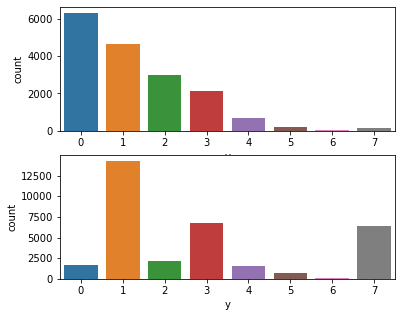

In [17]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [18]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [19]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.1940157582339386, 0.12608422222851565)

In [20]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"042_submission.csv","Stratified-Kfold(K=5)","0.194016","0.126084","","CatBoostベクトルは除外"


In [21]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 15.6 ms


In [22]:
imp_df

,feature,importance,fold
0,batterID,6.672134,1
1,pitcherID,5.057314,1
2,Match,0.000000,1
3,isBatterHandLeft,0.383391,1
4,isPitcherHandLeft,0.112657,1
...,...,...,...
114,distDirV,0.638175,5
115,distDirW,0.646820,5
116,distDirX,0.366589,5
117,distDirY,0.000000,5


In [23]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [24]:
coef_df

""
